## 본 연습은 inflearn - 박조은 강사님의 Code를 활용하여, 변경함

### original 내용
### 인프런 2020년 새해 다짐 이벤트 댓글 분석
* https://www.inflearn.com/pages/newyear-event-20200102
* 영상 튜토리얼 : [댓글 수백 수천개 분석하기?! [1/5] 이벤트 데이터 크롤링 feat. 인프런 새해 다짐 이벤트 - YouTube](https://www.youtube.com/watch?v=OUSwQk79H8I&list=PLaTc2c6yEwmohRzCxWQqJ7Z9aqc-sQ5gC)

### 기획자나 마케터가 되어 이벤트 댓글을 분석해 보자!
#### 내가 만약 수백 수천개의 댓글을 다 읽어봐야 한다면?
#### 댓글 속에 제품에 대한 관심을 빈도수로 추출해야 한다면?
* 쇼핑몰에서 제품 관련 이벤트 진행시 어떤 제품을 고객이 선호하는지 알고 싶다면?
* 고객 DB와 연계할 수 있다면 이벤트 혹은 마케팅 세그먼트로 활용해 볼 수도 있지 않을까?

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline
# 시각화 결과가 선명하게 표시되도록
%config InlineBackend.figure_format = 'retina'

## 시각화를 위한 한글폰트 설정

In [2]:
# Window 한글폰트 설정
# plt.rc("font", family="Malgun Gothic")
# Mac 한글폰트 설정
plt.rc("font", family="AppleGothic")
plt.rc('axes', unicode_minus=False)

## 크롤링한 파일 로드하기

In [3]:
df = pd.read_csv("D:\\★2020_ML_DL_Project\\Alchemy\\ML_Area\\data_source\\inflearn-event.csv")
df.shape

(2435, 1)

In [4]:
df.head()

,text
0,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.
1,2020년 목표 - 안주하지 않기
2,"자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법"
3,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요
4,"2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정"


In [5]:
df.index.is_unique

True

## 데이터 전처리

### 네트워크 오류 등으로 발생한 중복 입력 값을 제거
* 빈도 수 중복을 방지하기 위해

In [6]:
print(df.shape)
df = df.drop_duplicates(["text"], keep="last") ## first 등 가능
print(df.shape)

(2435, 1)
(2398, 1)


### 원본은 따로 보존

In [7]:
# 전처리 전에 원본을 보존하기 위해 복사해 둠
df["origin_text"] = df["text"]
df.head()

,text,origin_text
0,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.
1,2020년 목표 - 안주하지 않기,2020년 목표 - 안주하지 않기
2,"자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법","자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법"
3,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요
4,"2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정","2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정"


### 소문자 변환

In [8]:
# 파이썬은 대소문자를 구분하기 때문에 데이터 필터링을 위해 대문자를 모두 소문자로 변경
# df["text"] = df["text"].str.lower()
df["text"] = df["text"].apply(lambda x : x.lower()) ## 이렇게도 변환가능

In [9]:
## 유사한 의미의 동의어, 유의어 처리하기
## koran language 사전이 있어서 그걸 활용하는 법도 있는것으로 알지만, 일단 pass
# 같은 의미의 단어를 하나로 통일 예) python => 파이썬
df["text"] = df["text"].str.replace(
    "python", "파이썬").str.replace(
    "pandas", "판다스").str.replace(
    "javascript", "자바스크립트").str.replace(
    "java", "자바").str.replace(
    "react", "리액트").str.replace("파이선","파이썬")

### 텍스트로 관심 강의 분리

In [10]:
print(pd.get_option("display.max_columns"))
df.text.tail(10)

20


2425    5년째 퍼블리셔로 일하고 있는 직장인입니다. 제 30대가 더 깊어지기전에 프론트엔드...
2426    회사에서 그로스해킹을 해야되는데 이번에 올라온 강의를 듣고 팀을 만들고 싶어요!!\...
2427      큰그림은 구체적으로 그리고 밑그림은 섬세하게 그릴 수 있는 배움의 한해를 기원합니다.
2428    컴공으로 졸업을 했는데... 올해는 꼭 ios 개발자로 취업하고 싶어요!!\n#관심...
2429    스프링에 대해서 잘 모르는 것이 많은데 올해는 인프런을 통해서 배우고 활용하고 싶습...
2430    작년 한해도 일이 바쁘다, 야근해서 힘들다는 핑계로 김영한님의 jpa 강의를 또 스...
2431    저는 졸업을 1년 남기고 있는 컴퓨터공학과 학생입니다. 졸업 프로젝트로 웹/앱 개발...
2432    에프터 이펙트를 써본 적은 있는데, 매번 기초만 배우다 말았어요. 이걸 할 줄 안다...
2433    저번에 인프런에서 페이스북 마케팅 강의를 듣고 많은 도움을 받았습니다. 마케팅 업무...
2434    인프런 0호 팀원이에요!\n그동안 서비스 개발 때문에 js 를 많이 했었는데 앞으론...
Name: text, dtype: object

In [11]:
 ## 예시 데이터
df["text"][10].split("관심강의")[-1]

': 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기\n파이썬의 고수가 되고싶어요'

In [12]:
df["course"] = df["text"].apply(lambda x: x.split("관심강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강좌")[-1])
df["course"] = df["course"].str.replace(":", "")
df["course"].head()

0                2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.
1                             2020년 목표 - 안주하지 않기
2     자바 공부 마스터 하고 싶습니다.   더 자바, 코드를 조작하는 다양한 방법
3                 파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요
4    2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정
Name: course, dtype: object

In [13]:
df[["text", "course"]].head()

,text,course
0,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.
1,2020년 목표 - 안주하지 않기,2020년 목표 - 안주하지 않기
2,"자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법","자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법"
3,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요
4,"2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정","2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정"


## 띄어 쓰기를 제거한 텍스트에서 키워드 추출
* TIOBE 프로그래밍 언어 순위 : [index | TIOBE - The Software Quality Company](https://www.tiobe.com/tiobe-index/?fbclid=IwAR34dJfgDHq2DK0C6X3g8IsUno2NhOiikMyxT6fw9SoyujFhy5FPvQogMoA)

### tip 
df["course"].str처럼 course 의 value 들이 str 타입일때, str 오브젝트의 함수를 쓰기 위해선, "str." 을 반드시 해줘야 한다. 
#### df["course"].contains(keyword) --> 100% error

In [14]:
search_keyword = ['머신러닝', '딥러닝', '파이썬', '판다스', '공공데이터',
                  'django', '크롤링', '시각화', '데이터분석', 
                  '웹개발', '엑셀', 'c', '자바', '자바스크립트', 
                  'node', 'vue', '리액트']
## search_keyword 갯수만큼 컬럼생성 
for keyword in search_keyword:
    df[keyword] = df["course"].str.contains(keyword)

In [15]:
df.head()

,text,origin_text,course,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트
0,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2020년 목표 - 안주하지 않기,2020년 목표 - 안주하지 않기,2020년 목표 - 안주하지 않기,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,"자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법","자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법","자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법",False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,"2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정","2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정","2020년도 화이팅!, 스프링 프레임워크 개발자를 위한 실습을 통한 입문 과정",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [16]:
df_python = df[df["text"].str.contains("파이썬|공공데이터|판다스")].copy()
df_python.shape

(430, 20)

In [17]:
df_python.loc[:,["파이썬","공공데이터","판다스"]].sum()

파이썬      406
공공데이터     12
판다스        6
dtype: int64

In [18]:
# True + True + False

In [19]:
df[search_keyword].sum().sort_values(ascending=False)

c         407
파이썬       406
자바        341
자바스크립트    140
리액트       133
머신러닝      133
vue       132
node      116
크롤링        55
딥러닝        53
django     31
시각화        29
웹개발        27
데이터분석      24
엑셀         18
공공데이터      12
판다스         6
dtype: int64

In [20]:
text = df.loc[(df["공공데이터"] == True), "text"]
for t in text:
    print("-"*20)
    print(t)

--------------------
#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
파이썬의 고수가 되고싶어요
--------------------
자바기반 웹 개발자입니다. 데이터 분석에 많이 쓰이는 파이썬이 궁금합니다.
#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
올해 안에 원하는 공부 다 끝내보려고요. 내년이면 수능이라..

#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
it개발자입니다. 개발을 오래 안하고 관리만 했더니 다시 개발이 너무 하고싶습니다. 올해는 인프런을 통해서 개발쪽 스킬셋을 업그레이드 하고 싶습니다!
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
파이썬 데이터분석 마스터
#관심강의:공공데이터로 파이썬 데이터 분석 시작하기
--------------------
올해 졸업하는 컴퓨터공학과 학생입니다!
백엔드 혹은 데이터 엔지니어 쪽으로 취업하고 싶습니다!
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
텍스트 마이닝만 수강한 뒤 현재 맡은 마케팅 업무 능률이 엄청나게 올라가는 것을 확인했으며 승진과 고가에 엄청나게 득을 보았습니다 감사합니다! 앞으로도 인프런 애용하겠습니다.
추가적으로 해 박조은 강사님의 [공공데이터로 파이썬 데이터 분석 시작하기] 강의를 듣고 상권분석과 공공데이터 활용 역량을 올릴 예정입니다. 화이팅!!!
#관심강의 : 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
데이터분석 2년차가 되는데 작년에 파이썬 강의를 담아놓고 그대로 1년간 방치... 올해는 꼭 완강하고 실습해서 개발자에게 의존하지 않고 혼자 크롤링&분석 해내고 싶어요! 
#관심강의: 공공데이터로 파이썬 데이터분석 시작하기, database 1&2 - mysql
------

## 판다스 단어가 들어가는 텍스트만 찾기
* 이미 str.contains 를 통해 판다스가 들어가는 텍스트에 대해 컬럼을 만들어 놨습니다. 이 값이  True 라면 판다스 강좌 입니다.

In [21]:
df.loc[df["판다스"] == True, "text"]

526     2020년에는 데이터분석 관련한 실력을 쌓고싶습니다!\n#관심강의 : 파이썬, 판다...
675     취미로 안드로이드 개발하는 사람입니다. 자바로 작성하다 보니, kotlin이 안드로...
743          판다스 라입러리에 관심이 많아서 배워보려 합니다 #관심강의 : 박조은 - 판다스
1222      2020년!! 올 해는 빅데이터 분석 전문가 되기!!\n#관심강의 : 파이썬, 판다스
2141    2020년 목표  파이썬 을  활용해  데이터 분석 작업을 진행하고 싶습니다.  관...
2351    저는 백세시대에 조금 더 오랫동안 it일을 하기위해서 it전략기획에서 데이터분석가로...
Name: text, dtype: object

## 빈도수 계산을 위한 텍스트 데이터 벡터화
* BOW 단어 가방에 단어를 토큰화 해서 담아줌

## CountVectorizer 이용 하기 "sklearn.feature_extraction.text"

In [22]:
# 토큰화
"파이썬 데이터 분석".split()

['파이썬', '데이터', '분석']

In [23]:
df.head(3)

,text,origin_text,course,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트
0,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.,2020년에는 데이터를 좀 더 열심히 공부하려고 합니다.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2020년 목표 - 안주하지 않기,2020년 목표 - 안주하지 않기,2020년 목표 - 안주하지 않기,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,"자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법","자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법","자바 공부 마스터 하고 싶습니다. 더 자바, 코드를 조작하는 다양한 방법",False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다. (한글자씩도 할 수 있다는 뜻)
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
                             ngram_range=(3, 6), # BOW의 단위 갯수의 범위를 지정합니다. (몇개의 단어씩 묶을지 결정하는 것)
                             max_features = 2000 # 만들 피처의 수, 단어의 수
                            )
vectorizer
## vectorizer 객체를 만들었다. 이를 통해, transform 하는 것

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(3, 6), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [25]:
## course 컬럼에 대해서, 변형(fit_transform)을 시킨다.
feature_vector = vectorizer.fit_transform(df['course'])
feature_vector.shape

(2398, 2000)

In [26]:
print(type(feature_vector))
# print(feature_vector) ## 의미없음. matrix 객체이니, 거기에 맞춰서 봐야 함
print("feature_vector.shape",feature_vector.shape,"\n","feature_vector.ndim",feature_vector.ndim)

<class 'scipy.sparse.csr.csr_matrix'>
feature_vector.shape (2398, 2000) 
 feature_vector.ndim 2


#### from scipy.sparse import csr_matrix
참조 : https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [27]:
feature_vector.toarray()[1:10,:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [28]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10] ## 컬럼벡터의 이름인듯
## 3개 ~ 6개의 단어로 묶어서 벡터화 하였다.

2000


['12개 만들면서 배우는',
 '12개 만들면서 배우는 ios',
 '12개 만들면서 배우는 ios 아이폰',
 '12개 만들면서 배우는 ios 아이폰 개발',
 '12개를 만들며 배우는',
 '12개를 만들며 배우는 swift4',
 '12개를 만들며 배우는 swift4 ios11',
 '12개를 만들며 배우는 swift4 ios11 아이폰',
 '2018 do it',
 '2018 do it 안드로이드']

In [29]:
# 각 리뷰마다 등장하는 단어에 빈도수가 표현됩니다. 0 은 등장하지 않음을 의미합니다.
## feature_vector 를 10행*전체열 가져와서, array -> dataframe 2번 변환
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head(10)

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# 위에서 구한 단어벡터를 더하면 단어가 전체에서 등장하는 횟수를 알 수 있습니다.
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0) ## feature_vector type 은 csr.matrix 임
    
df_freq = pd.DataFrame(dist, columns=vocab)
df_freq

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,2,2,2,2,2,2,2,2,2,2,...,16,13,13,12,2,8,8,2,2,2


In [31]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬
df_freq.T.sort_values(by=0, ascending=False).head(10)

,0
홍정모의 따라하며 배우는,100
스프링 데이터 jpa,60
nodebird sns 만들기,59
파이썬 머신러닝 완벽,49
머신러닝 완벽 가이드,49
프로그래밍과 자바스크립트 es6,48
리액트로 nodebird sns 만들기,48
리액트로 nodebird sns,48
파이썬 머신러닝 완벽 가이드,48
2020년 공부 목표,47


In [32]:
## 상기 결과와 같은걸 stack 으로도 할 수 있음 근데 권장안함. stack , unstack 은 multiIndex 에서 사용해야 덜 헷갈림 by JJH
pd.DataFrame(df_freq.stack(level=-1)[0][:]).sort_values(by=0, ascending=False).head(10)

,0
홍정모의 따라하며 배우는,100
스프링 데이터 jpa,60
nodebird sns 만들기,59
파이썬 머신러닝 완벽,49
머신러닝 완벽 가이드,49
프로그래밍과 자바스크립트 es6,48
리액트로 nodebird sns 만들기,48
리액트로 nodebird sns,48
파이썬 머신러닝 완벽 가이드,48
2020년 공부 목표,47


In [33]:
df_freq_T = df_freq.T.reset_index()
df_freq_T.columns = ["course", "freq"]
# 강의명을 토큰 3개로 중복제거하기 위해, 강좌명에서 지식공유자의 이름을 빈문자열로 변경
df_freq_T["course_find"] = df_freq_T["course"].str.replace("홍정모의", "")
df_freq_T["course_find"] = df_freq_T["course_find"].apply(lambda x : " ". join(x.split()[:4]))
# df_freq_T.head()
df_freq_T.sort_values(["course_find", "freq"], ascending=False).head(10)

,course,freq,course_find
1999,활용한 파이썬 프로그래밍,2,활용한 파이썬 프로그래밍
1998,활용한 메신져 만들기 android,2,활용한 메신져 만들기 android
1997,활용한 메신져 만들기,2,활용한 메신져 만들기
1996,활용한 리액트 native 개발,8,활용한 리액트 native 개발
1995,활용한 리액트 native,8,활용한 리액트 native
1994,활용한 데이터분석과 it보안,2,활용한 데이터분석과 it보안
1992,활용한 다양한 자동화 어플리케이션,13,활용한 다양한 자동화 어플리케이션
1993,활용한 다양한 자동화 어플리케이션 제작하기,12,활용한 다양한 자동화 어플리케이션
1991,활용한 다양한 자동화,13,활용한 다양한 자동화
1989,활용2 api 개발과 성능,16,활용2 api 개발과 성능


In [34]:
# 3개의 ngram과 빈도수로 역순 정렬을 하게 되면 빈도수가 높고, ngram수가 많은 순으로 정렬이 됨 
# 여기에서 첫 번째 강좌를 남기고 나머지 중복을 삭제
print(df_freq_T.shape)
df_course = df_freq_T.drop_duplicates(["course_find", "freq"], keep="first")
print(df_course.shape)

(2000, 3)
(1438, 3)


In [35]:
df_course = df_course.sort_values(by="freq", ascending=False)
df_course.head(20)

,course,freq,course_find
1965,홍정모의 따라하며 배우는,100,따라하며 배우는
1077,스프링 데이터 jpa,60,스프링 데이터 jpa
320,nodebird sns 만들기,59,nodebird sns 만들기
925,머신러닝 완벽 가이드,49,머신러닝 완벽 가이드
1738,파이썬 머신러닝 완벽,49,파이썬 머신러닝 완벽
1868,프로그래밍과 자바스크립트 es6,48,프로그래밍과 자바스크립트 es6
904,리액트로 nodebird sns 만들기,48,리액트로 nodebird sns 만들기
1739,파이썬 머신러닝 완벽 가이드,48,파이썬 머신러닝 완벽 가이드
903,리액트로 nodebird sns,48,리액트로 nodebird sns
11,2020년 공부 목표,47,2020년 공부 목표


In [36]:
df_course.to_csv("D:\\★2020_ML_DL_Project\\Alchemy\\ML_Area\\data_source\\event-course-name-freq.csv")

#### 위에까지가 bag-of-word 영역이라면, 밑에서부터, TF-IDF 영역인데, TF-IDF에서 위에서 만들었던, bag-of-world matrix를 활용(파라미터)로 받는다
#### 이론적 조사가 좀더 필요하다.

## TF-IDF 로 가중치를 주어 벡터화
### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정합니다.
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값(유클리디안거리)
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절(맨하탄거리)
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

#### 원전자는 tf-idf 의 가중치를 더 줘서, 묶었다고 표현한다.

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [38]:
feature_vector

<2398x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 11565 stored elements in Compressed Sparse Row format>

In [39]:
%%time 
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

Wall time: 973 µs


(2398, 2000)

In [40]:
feature_tfidf

<2398x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 11565 stored elements in Compressed Sparse Row format>

In [41]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector에 TF-IDF 가중치 반영
tfidf_freq = pd.DataFrame(feature_tfidf.toarray(), columns=vocab)
tfidf_freq.head() 

,12개 만들면서 배우는,12개 만들면서 배우는 ios,12개 만들면서 배우는 ios 아이폰,12개 만들면서 배우는 ios 아이폰 개발,12개를 만들며 배우는,12개를 만들며 배우는 swift4,12개를 만들며 배우는 swift4 ios11,12개를 만들며 배우는 swift4 ios11 아이폰,2018 do it,2018 do it 안드로이드,...,활용2 api 개발과 성능 최적화,활용한 다양한 자동화,활용한 다양한 자동화 어플리케이션,활용한 다양한 자동화 어플리케이션 제작하기,활용한 데이터분석과 it보안,활용한 리액트 native,활용한 리액트 native 개발,활용한 메신져 만들기,활용한 메신져 만들기 android,활용한 파이썬 프로그래밍
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df_tfidf = pd.DataFrame(tfidf_freq.sum())
df_tfidf_top = df_tfidf.sort_values(by=0, ascending=False)
df_tfidf_top.head(10)

,0
홍정모의 따라하며 배우는,66.597110
스프링 데이터 jpa,35.549412
nodebird sns 만들기,26.418976
파이썬 머신러닝 완벽,24.811553
머신러닝 완벽 가이드,24.563876
파이썬 머신러닝 완벽 가이드,23.911946
리액트로 nodebird sns,23.776826
리액트로 nodebird sns 만들기,23.776826
프로그래밍과 자바스크립트 es6,19.510529
함수형 프로그래밍과 자바스크립트 es6,18.595669


In [43]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
for t in df_tfidf_top.index[:30]:
    print(t)

홍정모의 따라하며 배우는
스프링 데이터 jpa
nodebird sns 만들기
파이썬 머신러닝 완벽
머신러닝 완벽 가이드
파이썬 머신러닝 완벽 가이드
리액트로 nodebird sns
리액트로 nodebird sns 만들기
프로그래밍과 자바스크립트 es6
함수형 프로그래밍과 자바스크립트 es6
함수형 프로그래밍과 자바스크립트
부트 개념과 활용
스프링 부트 개념과
스프링 부트 개념과 활용
2020년 공부 목표
실전 스프링 데이터
실전 스프링 데이터 jpa
파이썬 실전 100 활용
파이썬 실전 100
남박사의 파이썬 실전 100 활용
남박사의 파이썬 실전 100
남박사의 파이썬 실전
실전 100 활용
관심있는 인프런 강의명
파이썬 머신러닝 완벽가이드
따라하며 배우는 c언어
홍정모의 따라하며 배우는 c언어
rest api 개발
대세는 쿠버네티스 기초편
스프링부트 개념과 활용


## 군집화 
* [Comparison of the K-Means and MiniBatchKMeans clustering algorithms — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)
* cluster - MiniBatchKMeans

#### class sklearn.cluster.KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')

#### kcluster 객체에 fit 할 때는 기본적으로, 숫자형 값들만, 가능한다. 

In [44]:
## vocab 
feature_tfidf.toarray()[0:10,0:5]## feature_tfidf 이건 matrix

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [45]:
from sklearn.cluster import KMeans
from tqdm import trange
inertia = []

start = 30
end = 150

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
for i in trange(start, end):
    cls = KMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    inertia.append(cls.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [02:41<00:00,  1.35s/it]


Text(0.5, 1.0, 'KMeans Ellbow Method')

c:\programdata\anaconda3\envs\test\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


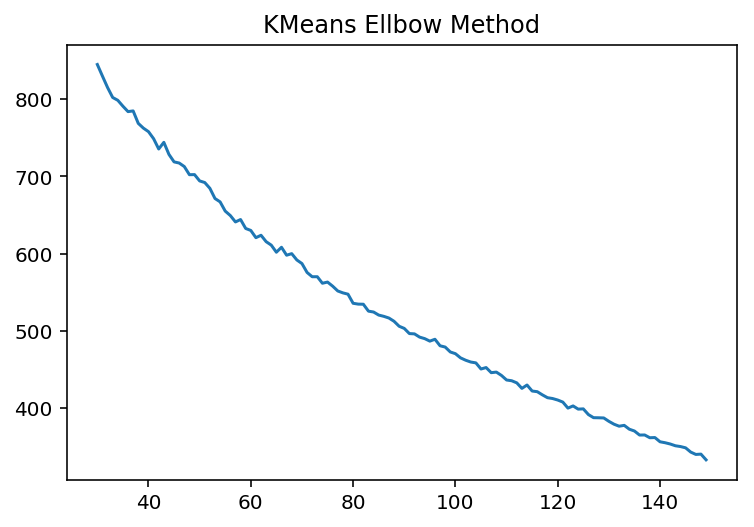

In [46]:
plt.plot(range(start, end), inertia)
plt.title("KMeans Ellbow Method")

####  하기 그림이 이론적으로 이상적인 Ellbow Method 인데...역시 실전은 다르다는 것을 느낀다.

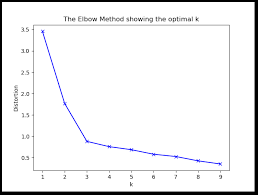

In [47]:
df.shape ## 원본 dataset 에서, dup 된것을 제거한 것.

(2398, 20)

In [48]:
## 대략적인 강좌수를 알고 있으니, 50으로 정했다. 
## feature_tfidf 이건 matrix
n_clusters = 50
cls = KMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["cluster"] = prediction

In [49]:
df["cluster"].value_counts().head(10)

1     1645
6       54
4       43
7       40
19      37
17      32
16      29
12      28
10      27
8       25
Name: cluster, dtype: int64

In [50]:
# batch_size 를 쓸 수 있는 MiniBatchKMeans 로 군집화
from sklearn.cluster import MiniBatchKMeans
b_inertia = []

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
for i in trange(start, end):
    cls = MiniBatchKMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    b_inertia.append(cls.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:23<00:00,  5.12it/s]


In [51]:
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")

Text(0.5, 1.0, 'MiniBatchKMeans Ellbow graph')

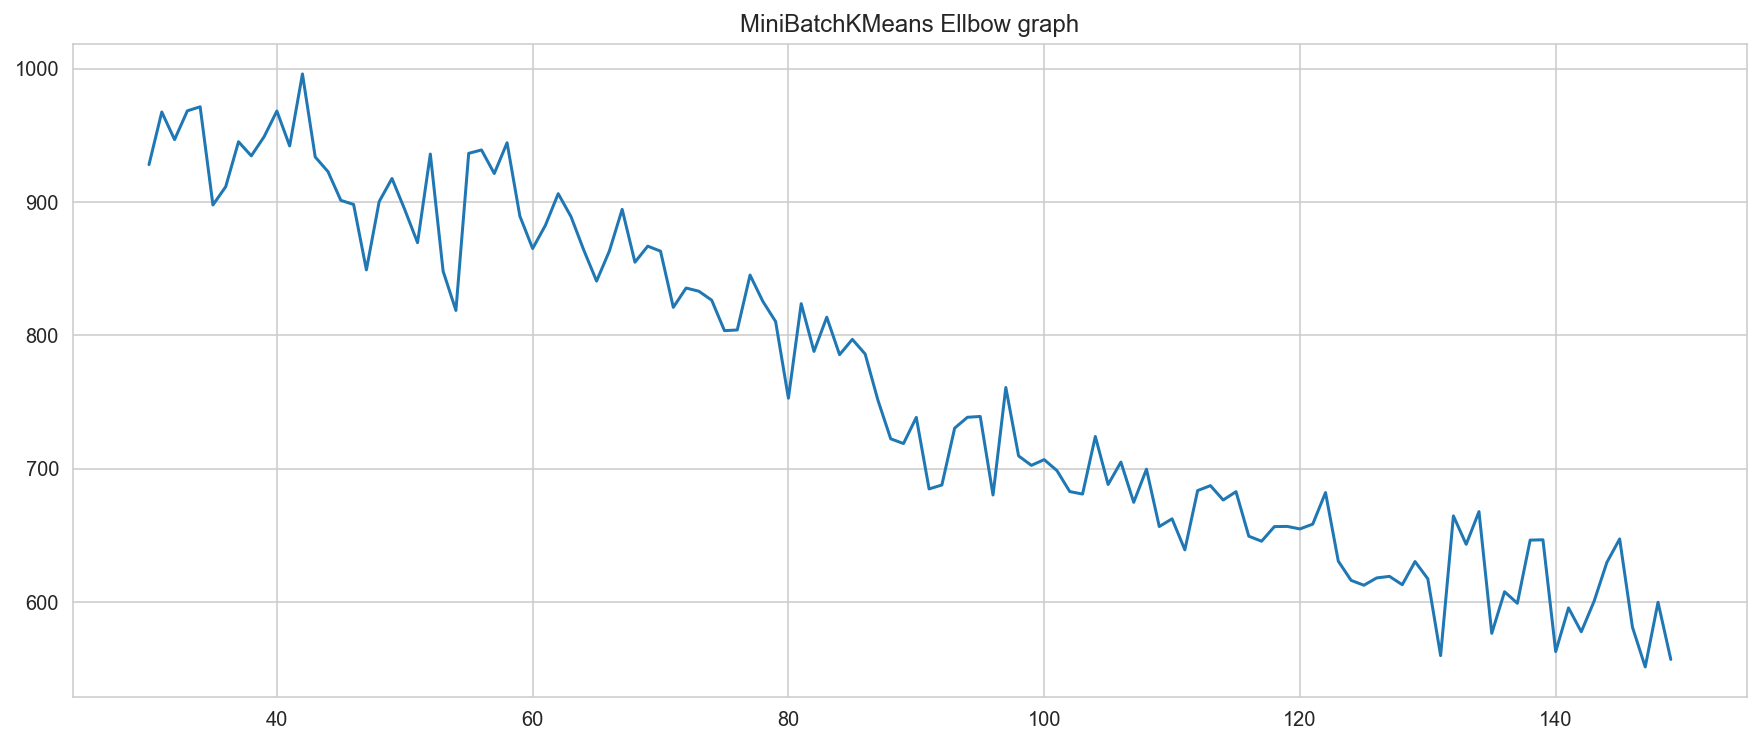

In [52]:
plt.figure(figsize=(15,6))
sns.lineplot(range(start, end), b_inertia)
plt.title("MiniBatchKMeans Ellbow graph")

In [53]:
## miniBatchKMean 에서는 나름 50 이 의미 있어 보인다.
print(n_clusters)

50


In [54]:
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["bcluster"] = prediction

In [55]:
df["bcluster"].value_counts().head(10)

14    1137
0      433
6       59
21      57
25      54
2       42
19      41
4       38
17      33
27      32
Name: bcluster, dtype: int64

In [56]:
df.loc[df["bcluster"] == 21, "course"].value_counts().head(1)

  '파이썬 기본부터 인공지능 머신러닝까지' 학습 로드맵    3
Name: course, dtype: int64

In [57]:
df.loc[df["bcluster"] == 21, ["bcluster", "cluster", "course"]]

,bcluster,cluster,course
29,21,22,"스프링 프레임워크 핵심 기술, 실전! 스프링부트와 jpa 활용2 - api 개발..."
33,21,22,"스프링 데이터 jpa, 실전! 스프링 부트와 jpa 활용2 - api 개발과 성..."
36,21,22,실전! 스프링 부트와 jpa 활용2 - api 개발과 성능 최적화
71,21,1,자바스크립트 es6+ 제대로 알아보기 - 초급
227,21,3,예민한 ux 디자인
316,21,1,마인크래프트 게임을 활용한 파이썬 프로그래밍 완벽 이해
356,21,1,자바 스프링 프레임워크(renew ver.) - 신입 프로그래머를 위한 강좌
364,21,1,자바 프로그래밍 공부를 하고싶어요!\n#자바 스프링 프레임워크(renew ver.)
406,21,1,c로 배우는 자료구조 및 여러가지 예제 실습
416,21,1,코딩테스트를 대비하기 위한 공부를 하고 싶습니다.


In [58]:
df.loc[df["bcluster"] == 24, ["bcluster", "cluster", "origin_text", "course"]].tail(10)

,bcluster,cluster,origin_text,course
94,24,45,딥러닝을 공부하여 인공지능에 한걸음 다가가고 싶습니다~~!!\n#관심강의 : [Op...,[opencv] 파이썬 딥러닝 영상처리 프로젝트 - 손흥민을 찾아라!
515,24,45,바빠서 밀어 두었던 인공지능과 데이터 사이언스를 다시 제대로 공부를 하려 합니다.\...,바빠서 밀어 두었던 인공지능과 데이터 사이언스를 다시 제대로 공부를 하려 합니다.\...
573,24,45,파이썬 로드맵에 따라 열심히 공부해서 데이터 사이언스 skill up 하려고 합니다...,파이썬 로드맵에 따라 열심히 공부해서 데이터 사이언스 skill up 하려고 합니다...
1245,24,45,내년에 졸업을 앞둔 비전공 개발자지망생 입니다. 최근에 finance machin...,[opencv] 파이썬 딥러닝 영상처리 프로젝트 - 손흥민을 찾아라!
1413,24,45,현재 현업에서 일하고 있습니다.\n머신러닝을 마스터하기 위해서 인프런에서 열심히 공...,"파이썬 데이터시각화 분석 실전 프로젝트, 파이썬을 활용한 데이터분석과 it보안..."
2384,24,45,2020년 공부목표:\n컴퓨터 공학을 전공하지 않았지만 소프트웨어 개발자로 일하고 ...,2020년 공부목표\n컴퓨터 공학을 전공하지 않았지만 소프트웨어 개발자로 일하고 있...
2405,24,45,2020년 공부목표: \n학교를 졸업한지 벌써 3년입니다. 졸업 할 때 만해도 무엇...,2020년 공부목표 \n학교를 졸업한지 벌써 3년입니다. 졸업 할 때 만해도 무엇이...


### 클러스터 예측 정확도 확인하기

In [59]:
len(np.unique(prediction))

45

In [60]:
print(type(prediction))
print(prediction.shape,prediction.ndim)

<class 'numpy.ndarray'>
(2398,) 1


In [61]:
a = np.array([0,1,2,3,4,5,0,1,2,3,4,5])
# ta = np.unique(a)
ta = np.array([3,4])
for t in ta:
    print(np.where(a==t))

(array([3, 9], dtype=int64),)
(array([ 4, 10], dtype=int64),)


In [64]:
np.argsort(a)[::-1]

array([11,  5, 10,  4,  9,  3,  8,  2,  7,  1,  6,  0], dtype=int64)

In [66]:
# n_clusters 위에서 정의한 클러스터 수를 사용
feature_array = feature_vector.toarray()
# 예측한 클러스터의 유니크 값
labels = np.unique(prediction)
df_cluster_score = []
df_cluster = []
# print(len(labels))
for label in labels:
    id_temp = np.where(prediction==label) # 예측한 값이 클러스터 번호와 매치 되는 것의 idx 값을 가져옴
    ## 1개씩이 아니라, 모두 가져옴. id_temp 는 여러개의 값을 가지는 prediction 의 idx 모음임
#     print(id_temp)
    x_means = np.mean(feature_array[id_temp], axis = 0) # 클러스터의 평균 값을 구함
#     print(x_means)
    sorted_means = np.argsort(x_means)[::-1][:n_clusters] # 값을 역순으로 정렬해서 클러스터 수 만큼 가져옴 여기선 50개 
    ## 평균값이 큰 값부터 가져온다
    features = vectorizer.get_feature_names()
    best_features = [(features[i], x_means[i]) for i in sorted_means] 
    # 클러스터별 전체 스코어
    df_score = pd.DataFrame(best_features, columns = ['features', 'score'])
#     print(df_score)
    df_cluster_score.append(df_score)
    # 클러스터 대표 키워드
    df_cluster.append(best_features[0])

In [67]:
df_score.shape

(50, 2)

In [68]:
feature_array[[3,1000,6,16]]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [71]:
type(df_cluster[0])
df_cluster[0]

('초심자를 위한 리액트', 0.046189376443418015)

In [77]:
# 개별 클러스터에서 점수가 가장 높은 단어를 추출 아래 점수가 클수록 예측 정확도가 높음
# MiniBatchKMeans 로 예측한 값 기준
pd.DataFrame(df_cluster, columns = ['features', 'score']).sort_values(by=["features", "score"], ascending=False)

,features,score
41,홍정모의 따라하며 배우는 c언어,1.000000
28,홍정모의 따라하며 배우는,2.000000
24,홍정모의 따라하며 배우는,1.000000
29,홍정모의 따라하며 배우는,0.473684
12,함수형 프로그래밍과 자바스크립트,1.000000
32,프로그래밍과 자바스크립트 es6,1.285714
26,표준 jpa 프로그래밍,1.000000
38,파이썬 입문 inflearn,1.000000
2,파이썬 머신러닝 완벽,1.000000
19,파이썬 데이터 분석,0.292683


In [80]:
# 정확도가 1이 나온 클러스터를 찾아봄 - 같은 강좌끼리 묶였는지 확인 함
df.loc[df["bcluster"] == 24, ["bcluster", "cluster", "origin_text", "course"]]

,bcluster,cluster,origin_text,course
94,24,45,딥러닝을 공부하여 인공지능에 한걸음 다가가고 싶습니다~~!!\n#관심강의 : [Op...,[opencv] 파이썬 딥러닝 영상처리 프로젝트 - 손흥민을 찾아라!
515,24,45,바빠서 밀어 두었던 인공지능과 데이터 사이언스를 다시 제대로 공부를 하려 합니다.\...,바빠서 밀어 두었던 인공지능과 데이터 사이언스를 다시 제대로 공부를 하려 합니다.\...
573,24,45,파이썬 로드맵에 따라 열심히 공부해서 데이터 사이언스 skill up 하려고 합니다...,파이썬 로드맵에 따라 열심히 공부해서 데이터 사이언스 skill up 하려고 합니다...
1245,24,45,내년에 졸업을 앞둔 비전공 개발자지망생 입니다. 최근에 finance machin...,[opencv] 파이썬 딥러닝 영상처리 프로젝트 - 손흥민을 찾아라!
1413,24,45,현재 현업에서 일하고 있습니다.\n머신러닝을 마스터하기 위해서 인프런에서 열심히 공...,"파이썬 데이터시각화 분석 실전 프로젝트, 파이썬을 활용한 데이터분석과 it보안..."
2384,24,45,2020년 공부목표:\n컴퓨터 공학을 전공하지 않았지만 소프트웨어 개발자로 일하고 ...,2020년 공부목표\n컴퓨터 공학을 전공하지 않았지만 소프트웨어 개발자로 일하고 있...
2405,24,45,2020년 공부목표: \n학교를 졸업한지 벌써 3년입니다. 졸업 할 때 만해도 무엇...,2020년 공부목표 \n학교를 졸업한지 벌써 3년입니다. 졸업 할 때 만해도 무엇이...


## WordCloud
* [amueller/word_cloud: A little word cloud generator in Python](https://github.com/amueller/word_cloud)
* 설치 방법 : [Wordcloud :: Anaconda Cloud](https://anaconda.org/conda-forge/wordcloud)

In [81]:
!pip install wordcloud

In [82]:
from wordcloud import WordCloud

# 불용어 - 자주 등장하지만 의미가 크지 않아 제외하고 싶은 텍스트
stopwords = ["관심 강의", "관심강의", "관심", "강의", "강좌", "강의를",
             "올해", "올해는", "열심히", "공부를", "합니다", "하고", "싶어요", 
             "있는", "있습니다", "싶습니다", "2020년"]
# 불용어를 제거하지 않고 그리려면 아래 주석을 풀어서 stopword 변수에 덮어쓰기를 합니다.
# stopwords = []
def displayWordCloud(data = None, backgroundcolor = 'black', width=1280, height=768):
    wordcloud = WordCloud(
                        font_path = '/Library/Fonts/NanumBarunGothic.ttf', 
                        stopwords = stopwords, 
                        background_color = backgroundcolor, 
                        width = width, height = height, 
                        random_state=42).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

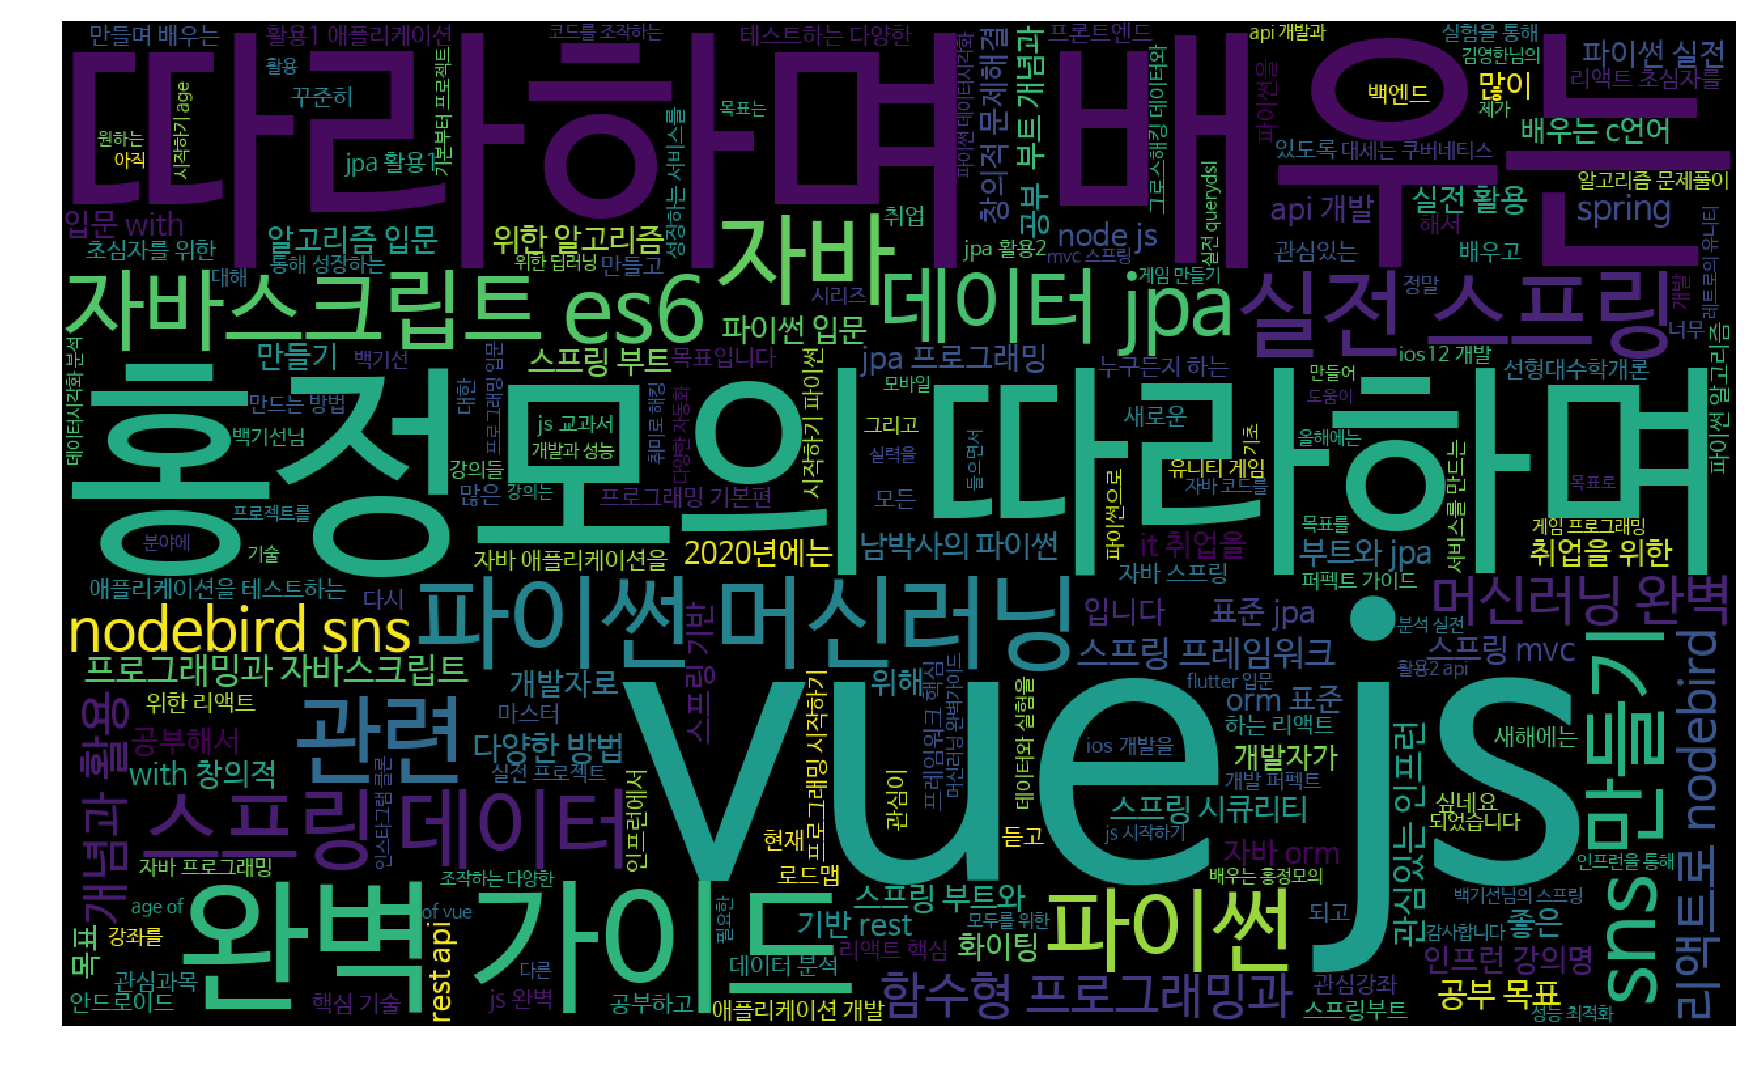

In [83]:
course_text = " ".join(df["course"])
displayWordCloud(course_text)